# Example Map Plotting

In [1]:
# By line: RRB 2020-07-20
# Script aims to:
# - Load a netCDF file
# - Extract one variable: CO
# - Calculate column values: load model pressure, multiply by ppb -> column conversion factor
# - Add cyclic point
# - Create contour plot of variable as world map with coastlines
# - Customize contours and colorbar
# - Add axes labels
# - Add grid lines

### At the start of a Jupyter notebook you need to import all modules that you will use.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                 # For plotting maps
import cartopy.feature as cfeature         # For plotting maps
from cartopy.util import add_cyclic_point  # For plotting maps
from pathlib import Path                   # System agnostic paths
import xarray as xr                        # For loading the data arrays
import numpy as np                         # For array creation and calculations

### Define the directories and file of interest for your results.

In [2]:
result_dir = Path("../../data")
file = "CAM_chem_merra2_FCSD_1deg_QFED_monthoutput_CO_201801.nc"
file_to_open = result_dir / file
#the netcdf file is now held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
nc_load = xr.open_dataset(file_to_open)
#to see what the netCDF file contains, uncomment below
#nc_load

### Extract the variable of choice at the time and level of choice.

In [3]:
#extract variable
var_sel = nc_load['CO'].isel(time=0)
#print(var_sel)

#select the surface level at a specific time and convert to ppbv from vmr
#select the surface level for an average over three times and convert to ppbv from vmr
var_sel = var_sel*1e09 # 10-9 to ppb
print(var_sel.shape)

#extract grid variables
lat = var_sel.coords['lat']
lon = var_sel.coords['lon']

(56, 192, 288)


### Define constants for converting to column amounts.

In [4]:
#-------------------------------
#CONSTANTS and conversion factor
#-------------------------------
NAv = 6.0221415e+23                       #--- Avogadro's number
g = 9.81                                  #--- m/s - gravity
MWair = 28.94                             #--- g/mol
xp_const = (NAv* 10)/(MWair*g)*1e-09      #--- scaling factor for turning vmr into pcol
                                          #--- (note 1*e-09 because in ppb)

### Create 3d Pressure array.
Calculates pressures at each hybrid level using the formula: p(k) = a(k)*p0 + b(k)*ps. 

In [5]:
# Load values to create true model pressure array
psurf = nc_load['PS'].isel(time=0)
hyai = nc_load['hyai']
hybi = nc_load['hybi']
p0 = nc_load['P0']
lev = var_sel.coords['lev']
num_lev = lev.shape[0]

# Initialize pressure edge arrays
mod_press_low = xr.zeros_like(var_sel)
mod_press_top = xr.zeros_like(var_sel)

# Calculate pressure edge arrays
# CAM-chem layer indices start at the top and end at the bottom
for i in range(num_lev):
    mod_press_top[i,:,:] = hyai[i]*p0 + hybi[i]*psurf
    mod_press_low[i,:,:] = hyai[i+1]*p0 + hybi[i+1]*psurf

# Delta P in hPa
mod_deltap = (mod_press_low - mod_press_top)/100
#print(mod_press_low[:,0,0])
#print(mod_press_top[:,0,0])
#print(mod_deltap[:,0,0])

### Calculate columns.

In [6]:
var_tcol = xr.dot(mod_deltap, xp_const*var_sel, dims=["lev"])

### Add cyclic point to avoid white stripe at lon=0.

In [7]:
var_tcol_cyc, lon_cyc = add_cyclic_point(var_tcol, coord=lon) 

### Plot the value over the globe.

In [8]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.ma.masked_array(np.interp(value, x, y))
        return res

[0.01       0.01129955 0.01276799 0.01442725 0.01630215 0.0184207
 0.02081457 0.02351953 0.02657601 0.0300297  0.03393222 0.03834189
 0.04332461 0.04895487 0.05531681 0.06250552 0.07062844 0.07980697
 0.0901783  0.10189744 0.11513954 0.13010252 0.14701002 0.16611474
 0.18770221 0.21209509 0.23965795 0.27080274 0.30599497 0.34576061
 0.39069399 0.44146671 0.4988376  0.56366414 0.63691523 0.71968567
 0.81321257 0.91889377 1.03830879 1.17324241 1.32571137 1.49799445
 1.69266662 1.91263744 2.16119462 2.44205309 2.75941059 3.11801034
 3.52321199 3.98107171]


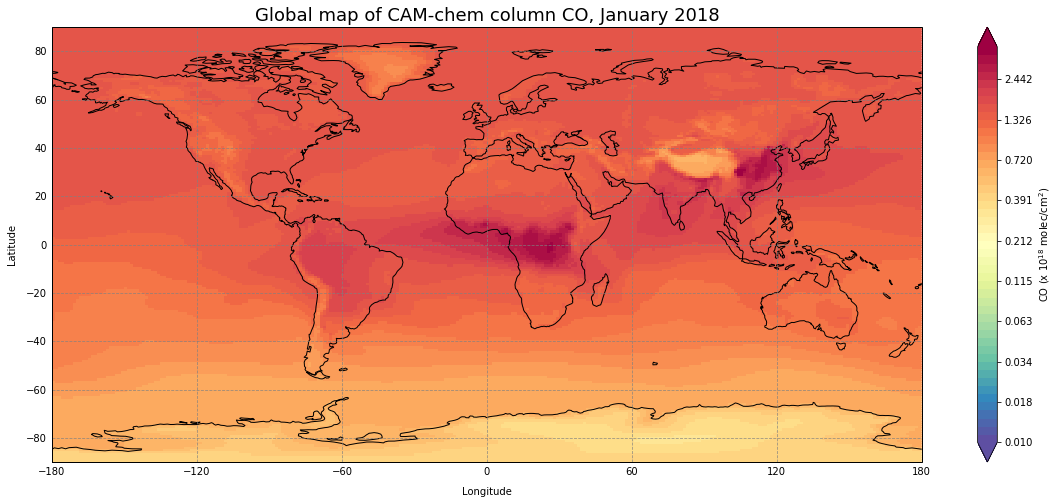

In [29]:
plt.figure(figsize=(20,8))

#Define projection
ax = plt.axes(projection=ccrs.PlateCarree())

#define contour levels
#clev = np.arange(0.5, 3.2, 0.1)


#clev = np.log10([0.1, 0.3, 0.5, 0.75, 1, 3, 5, 7.5,])
#clev = ([0.1, 1/3, 1/2, 1, 10/3, 10/2])
clev = np.logspace(-2, 0.6, num=50)
print(clev)


cmap=plt.get_cmap('Spectral_r')
from matplotlib.ticker import MaxNLocator
#levels = MaxNLocator(nbins=15).tick_values(0.4, 4.0)
levels = clev
from matplotlib.colors import BoundaryNorm
norm = BoundaryNorm(clev, ncolors=cmap.N, clip=True)

#log10((/ 1, 3, 5, 7.5, 10, 15, 20, 25, 30/))


#plot the data
#plt.contourf(lon_cyc,lat,var_tcol_cyc/1e18,clev,cmap='Spectral_r',extend='both')
#plt.contourf(lon_cyc,lat,var_tcol_cyc/1e18,clev,cmap='YlOrRd',extend='both')

from matplotlib import ticker
#plt.contourf(lon_cyc,lat,var_tcol_cyc/1e18,locator=ticker.LogLocator(subs=clev),cmap='YlOrRd',extend='both')
plt.pcolormesh(lon_cyc,lat,var_tcol_cyc/1e18,cmap='Spectral_r', transform=ccrs.PlateCarree(), norm=norm)
#plt.pcolormesh(lon_cyc,lat,var_tcol_cyc/1e18,cmap='Spectral_r', transform=ccrs.PlateCarree())


# add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Titles
# Main
plt.title("Global map of CAM-chem column CO, January 2018",fontsize=18)

# y-axis
ax.text(-0.04, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
# x-axis
ax.text(0.5, -0.08, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
# legend
ax.text(1.15, 0.5, 'CO (x 10$^{18}$ molec/cm$^{2}$)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)

#cbar.ax.set_xticklabels(clev)  # horizontal colorbar

cbar = plt.colorbar(extend='both')
#cbar.set_ticks(clev[1::3])
#cbar.set_ticklabels(clev[1::3])
plt.show() 